# CO₂ Emissions Prediction using OLS Regression
**A Statistical Approach to Environmental Modeling and Energy Policy Analysis**

---

## Executive Summary

This project develops an Ordinary Least Squares (OLS) regression model to predict state-level CO₂ emissions based on population and energy generation sources. The model achieves:

| Metric | Value | Interpretation |
|--------|-------|----------------|
| **R² (Training)** | 89.9% | Explains nearly 90% of CO₂ emission variability |
| **R² (Testing)** | 70.5% | Strong generalization to unseen states |
| **RMSE (Test)** | 0.466 log-units | ~30-50% prediction error on original scale |
| **Key Predictors** | 3 significant | Population, Coal, Wind |
| **Multicollinearity** | VIF < 1.5 | No redundant features |
| **Homoscedasticity** | p = 0.068 | Variance assumption satisfied |

**Business Value:**
- Enables evidence-based energy policy decisions
- Identifies high-impact emissions reduction strategies
- Provides interpretable insights for stakeholders
- Supports state-level climate action planning
- Demonstrates coal's dominant role in emissions
- Reveals unexpected relationship between wind and emissions (requires further investigation)

**Technical Approach:**
- Log-transformed skewed features for linearity
- Train/test split to prevent data leakage
- Stepwise feature selection via Wald tests (statsmodels)
- Comprehensive assumption validation (VIF, Durbin-Watson, Breusch-Pagan)
- Stable generalization with minimal overfitting

The model is designed as an **explanatory tool** for understanding emissions drivers and a **baseline predictor** for state-level CO₂ forecasting.

**Key Technologies:** Python, statsmodels, scikit-learn, pandas, matplotlib, seaborn

---

## Introduction to OLS Regression

**Ordinary Least Squares (OLS)** is a foundational regression technique used to estimate the linear relationship between independent variables (features) and a dependent variable (target). It works by finding the line (or hyperplane) that minimizes the sum of squared differences between observed values and predicted values.

**Key characteristics:**
- Provides interpretable coefficients for each predictor
- Assumes linear relationship between predictors and target
- Well-suited for inference (hypothesis testing) and prediction
- Transparent and explainable for policy applications
- Requires assumption validation (linearity, homoscedasticity, normality)

---

# Problem Definition

**Research Question:** Can state-level CO₂ emissions be accurately predicted from population and energy generation sources?

### Dataset Overview

This analysis uses the **Energy Generation by State and Technology (2009)** dataset from the National Renewable Energy Laboratory:

**Source:** 
- [Net Electricity Generation](https://www.eia.gov/electricity/data/browser/) 
- [Energy-Related Carbon Dioxide Emissions by State, 2005-2016](https://www.eia.gov/environment/emissions/state/analysis/) 
- [Population](https://www.census.gov/)

**Description:** Provides annual energy generation/ for all U.S. states by fuel source (e.g., coal, gas, solar, wind) in 2009, reported in MWh.

### Features

| Feature | Type | Description | Units |
|---------|------|-------------|-------|
| `population` | Numerical | State population | Count |
| `Biomass` | Numerical | Biomass energy generation | MWh |
| `Geothermal` | Numerical | Geothermal energy generation | MWh |
| `Solar` | Numerical | Solar energy generation | MWh |
| `Wind` | Numerical | Wind energy generation | MWh |
| `Hydro` | Numerical | Hydroelectric generation | MWh |
| `Coal` | Numerical | Coal energy generation | MWh |
| `Petroleum` | Numerical | Petroleum energy generation | MWh |
| `Gas` | Numerical | Natural gas generation | MWh |
| `Nuclear` | Numerical | Nuclear energy generation | MWh |
| `Other` | Numerical | Other energy sources | MWh |

### Target Variable
- `Carbon Dioxide emissions (million metric tons)`: State-level CO₂ emissions

---

## Analysis Pipeline

1. **Data Loading & Inspection** - Initial data quality assessment
2. **Exploratory Data Analysis & Linearity Validation** - Distributions, outliers, skewness detection + compare raw vs log features against log(CO₂)
3. **Train/Test Split & Feature Transformation** - 80/20 stratified split with proper scaling and log-transform skewed variables
4. **Model Training and Feature Selection** - Fit OLS on training data (statsmodels) and backward/forward stepwise regression
5. **Assumption Validation** - VIF, Durbin-Watson, Breusch-Pagan tests
6. **Model Evaluation** - Test set performance and generalization
7. **Interpretation & Recommendations** - Policy insights and next steps

---


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from scipy.stats import pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore", message="Glyph 8322")  # avoid CO₂ Arial glyph warning
plt.rcParams["figure.dpi"] = 120


## 1. Load & Inspect Data

In [2]:
# Display big numbers with commas instead of scientific notation
pd.options.display.float_format = '{:,.0f}'.format

raw_co2_data = pd.read_csv('../data/energy_by_state_and_sector.csv')
co2_data = raw_co2_data.copy()


# Keep relevant columns
cleaned_co2_data = co2_data[[
    'population', 'Carbon Dioxide emissions (million metric tons)',
    'Biomass', 'Geothermal', 'Solar', 'Wind', 'Hydro',
    'Coal', 'Petroleum', 'Gas', 'Nuclear', 'Other'
]].copy()

print('Dataset Shape:', cleaned_co2_data.shape)
print(f'Total observations: {cleaned_co2_data.shape[0]:,} | Features: {cleaned_co2_data.shape[1]}')
print('\n' + '='*80)
print('First few rows:')
print('='*80)
display(cleaned_co2_data.head())

print('\n' + '='*80)
print('Summary Statistics:')
print('='*80)
display(cleaned_co2_data.describe(include='all'))

print('\n' + '='*80)
print('Dataset Information:')
print('='*80)
cleaned_co2_data.info()

Dataset Shape: (51, 12)
Total observations: 51 | Features: 12

First few rows:


,population,Carbon Dioxide emissions (million metric tons),Biomass,Geothermal,Solar,Wind,Hydro,Coal,Petroleum,Gas,Nuclear,Other
0,4779736,120,"3,291,196",0,0,0,"11,753,493","55,659,872","163,054","32,369,863",39716204,"7,137"
1,710231,38,"4,255",0,0,"3,062","1,204,550","566,822","1,191,884","3,571,101",0,0
2,6392017,93,"159,646",0,"13,759","9,555","6,348,463","39,783,826","67,337","34,852,150",30661851,534
3,2915918,62,"1,478,310",0,0,0,"4,195,168","25,075,250","87,674","11,368,417",15169966,"24,019"
4,37253956,372,"6,062,630","13,022,836","611,763","5,764,637","27,707,085","1,948,279","1,638,019","115,749,546",31734676,"440,323"



Summary Statistics:


,population,Carbon Dioxide emissions (million metric tons),Biomass,Geothermal,Solar,Wind,Hydro,Coal,Petroleum,Gas,Nuclear,Other
count,51,51,51,51,51,51,51,51,51,51,51,51
mean,"6,053,834",105,"1,065,443","297,908","15,843","1,387,790","5,335,901","34,597,755","761,306","18,256,390","15,622,578","217,215"
std,"6,823,984",99,"1,284,526","1,831,934","87,726","3,050,631","12,057,598","34,413,517","1,716,192","34,443,036","20,487,102","421,015"
min,"563,626",3,0,0,0,0,0,0,124,0,0,0
25%,"1,696,962",40,"80,294",0,0,0,"571,692","4,271,175","47,676","1,618,324",0,661
50%,"4,339,367",82,"599,703",0,0,"213,224","1,576,275","29,084,699","170,674","6,424,511","8,816,673","33,633"
75%,"6,636,084",132,"1,510,963",0,0,"1,878,767","3,978,597","47,904,576","687,557","20,669,295","27,587,126","340,884"
max,"37,253,956",550,"6,062,630","13,022,836","611,763","19,367,239","73,932,815","139,106,597","8,962,843","191,652,532","94,050,482","2,576,795"



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 12 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   population                                      51 non-null     int64  
 1   Carbon Dioxide emissions (million metric tons)  51 non-null     int64  
 2   Biomass                                         51 non-null     float64
 3   Geothermal                                      51 non-null     float64
 4   Solar                                           51 non-null     float64
 5   Wind                                            51 non-null     float64
 6   Hydro                                           51 non-null     float64
 7   Coal                                            51 non-null     float64
 8   Petroleum                                       51 non-null     float64
 9   Gas                    

## 2. Exploratory Data Analysis
**Goal:** Identify distributions, outliers, and skewness to guide transformations.

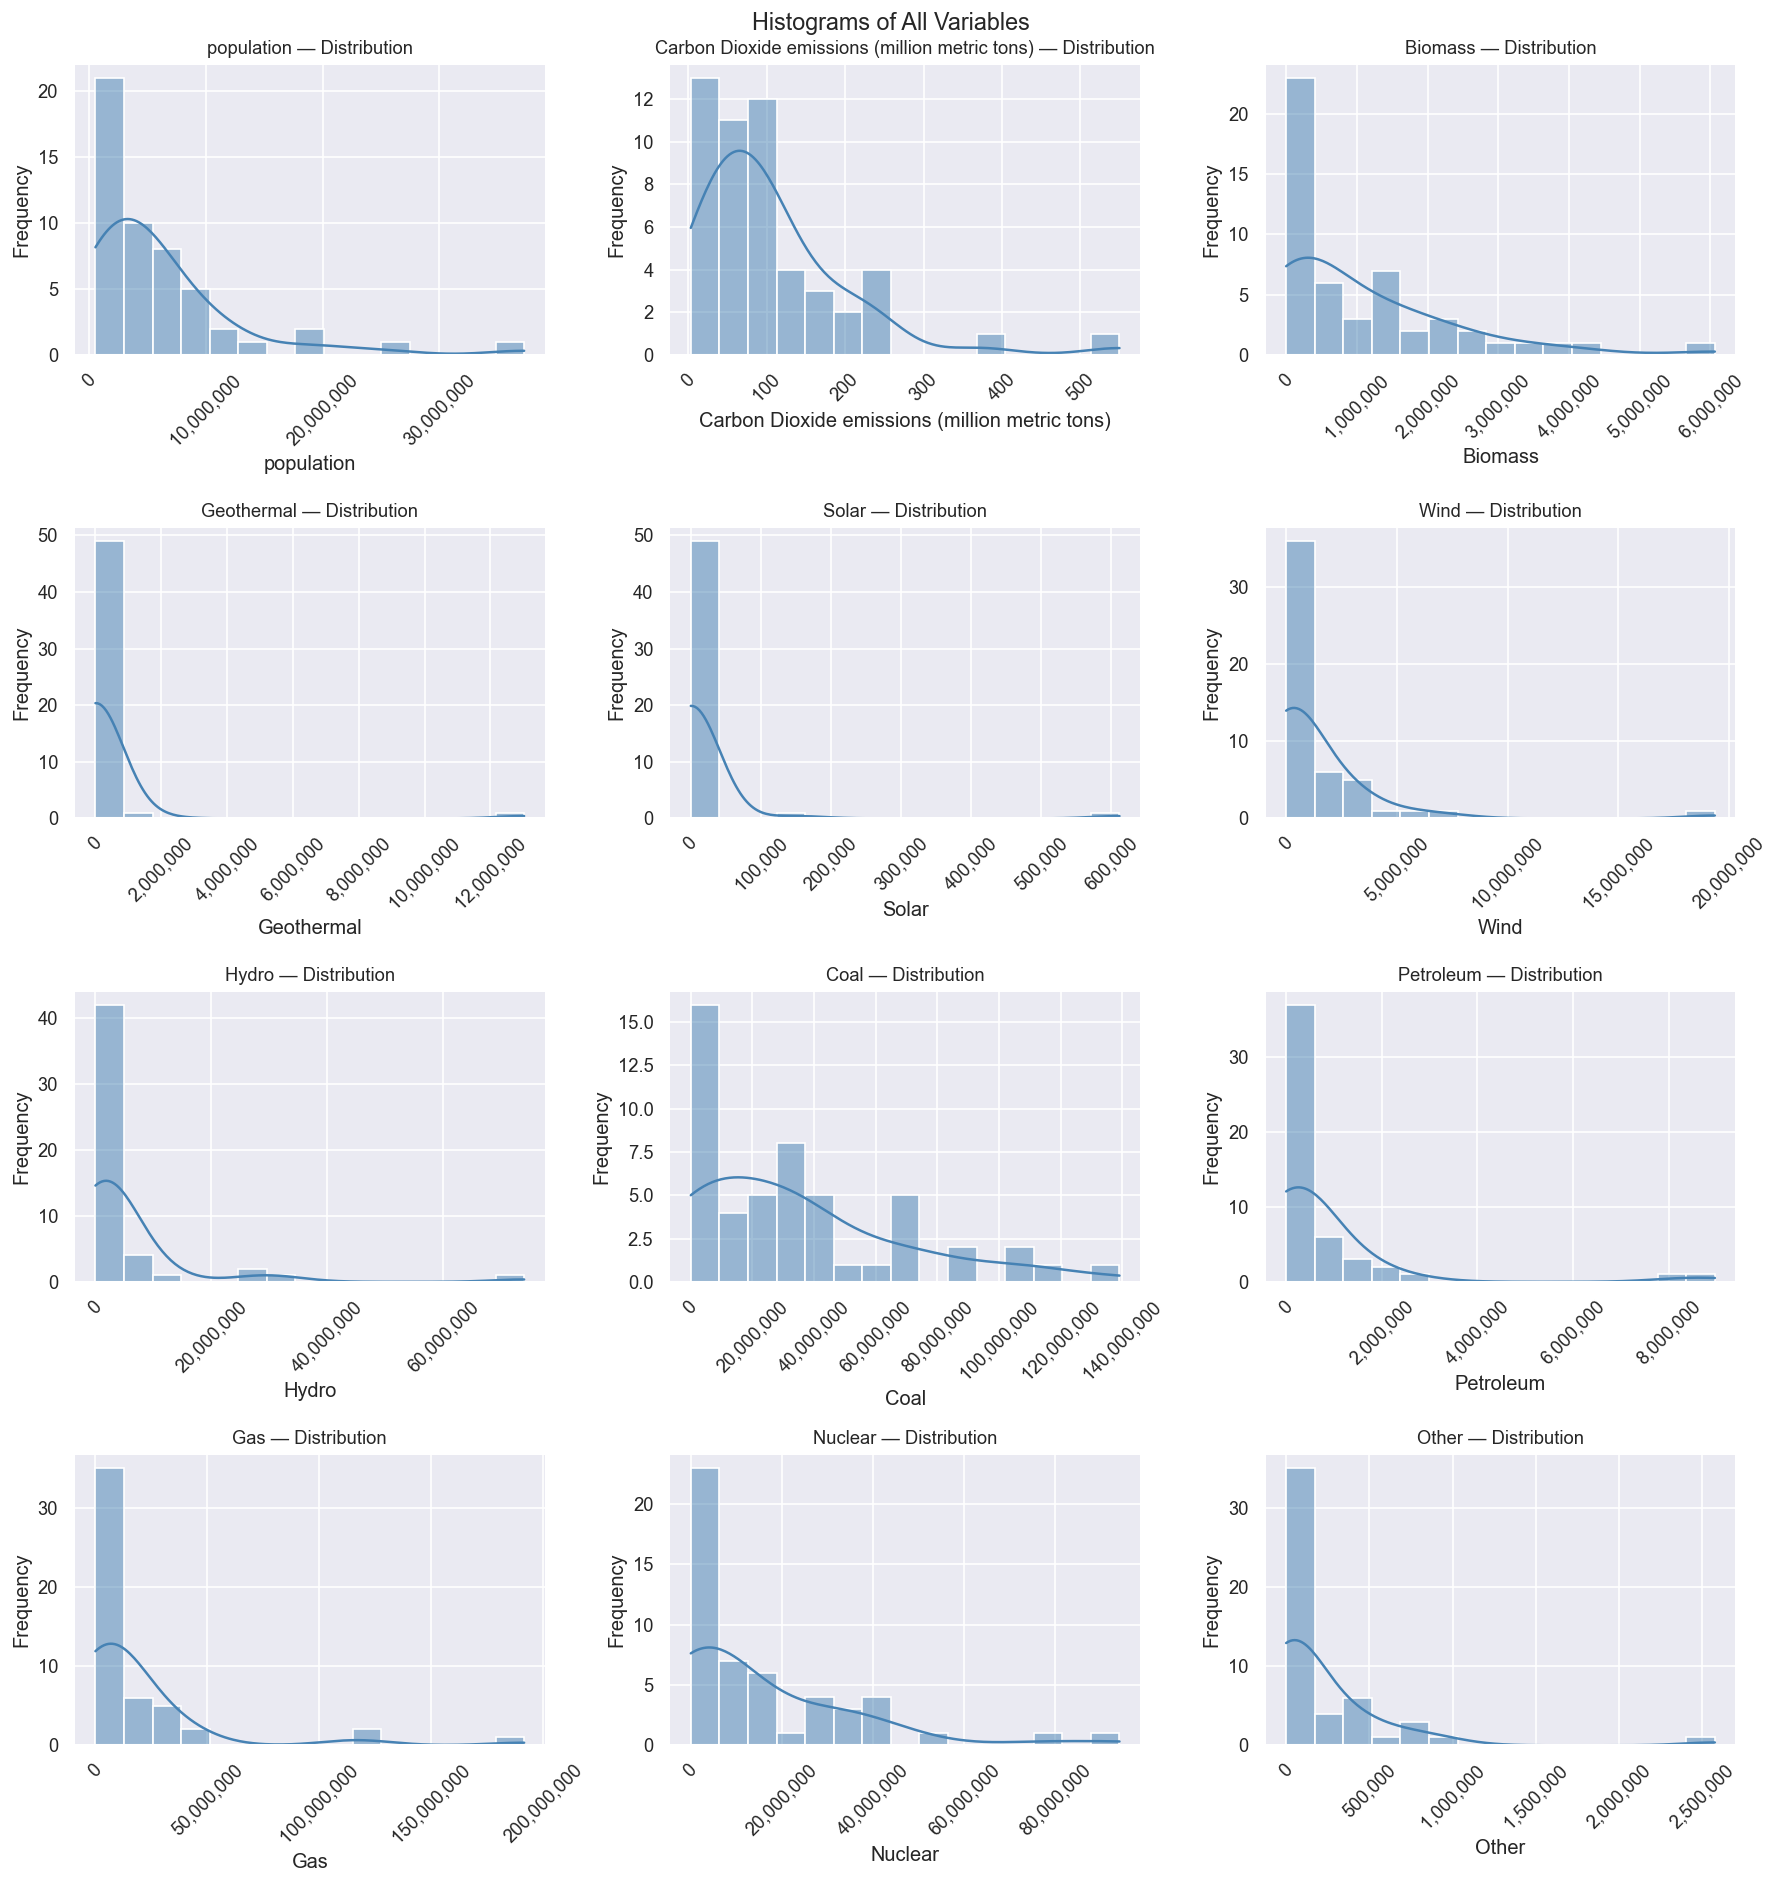

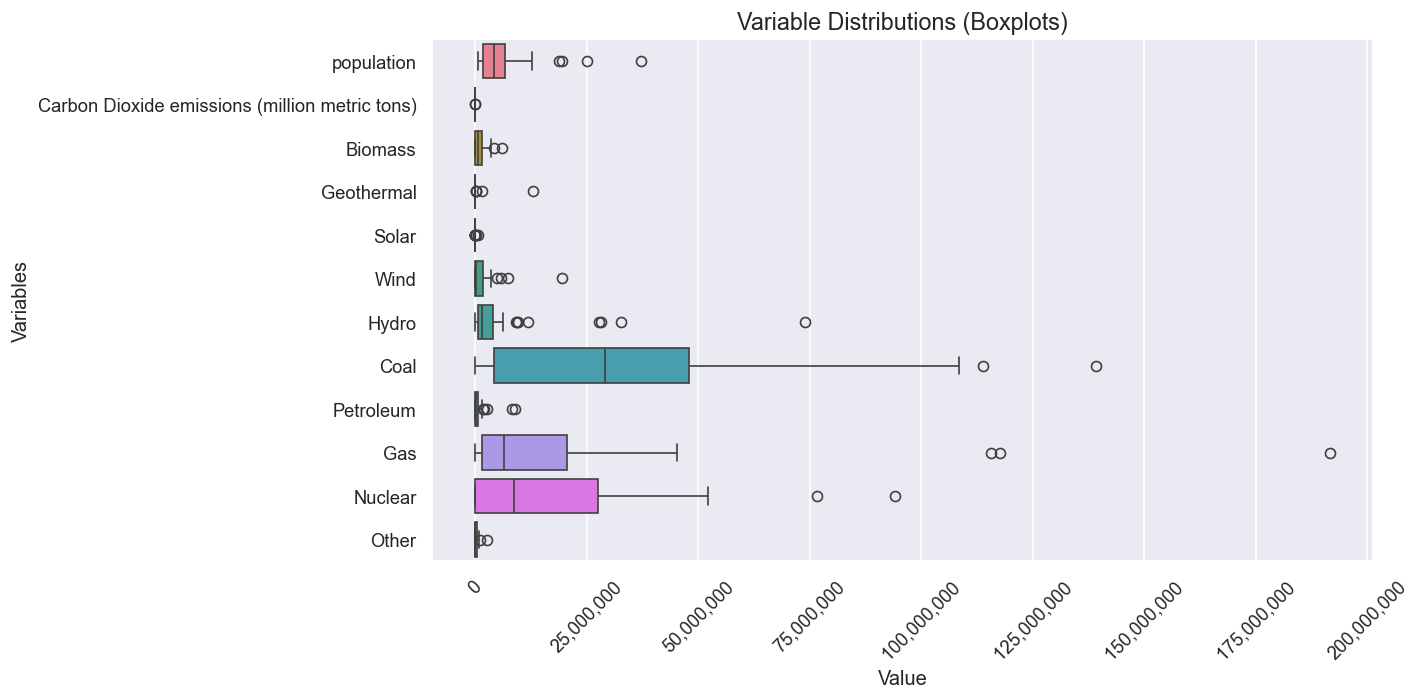

In [3]:
import matplotlib.ticker as mtick

# Formatter for comma-separated large numbers
comma_fmt = mtick.FuncFormatter(lambda x, pos: f'{int(x):,}')

numeric_cols = cleaned_co2_data.select_dtypes(include='number').columns

# Histograms (all numeric)
n_cols = 3
n_rows = int(np.ceil(len(numeric_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(cleaned_co2_data[col], bins=15, kde=True, color='steelblue', ax=axes[i])
    axes[i].set_title(f'{col} — Distribution', fontsize=11)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].xaxis.set_major_formatter(comma_fmt)
    axes[i].tick_params(axis='x', rotation=45)  # Rotate labels for readability

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Histograms of All Variables', fontsize=14)
plt.tight_layout()
plt.show()

# Condensed boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=cleaned_co2_data[numeric_cols], orient='h')
plt.title('Variable Distributions (Boxplots)', fontsize=14)
plt.xlabel('Value')
plt.ylabel('Variables')

# Apply comma formatting to x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(comma_fmt)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Key Observations:**
- Strong right skew observed for **population, CO₂, Coal, Petroleum, Gas, Nuclear**
- Outliers present but represent real extremes (e.g., California, Texas)
- Log transformation recommended for skewed variables

---

## 2.1 Log-Transform Skewed Features

**Rationale:** Log transformation reduces skewness, improves linearity, and stabilizes variance.

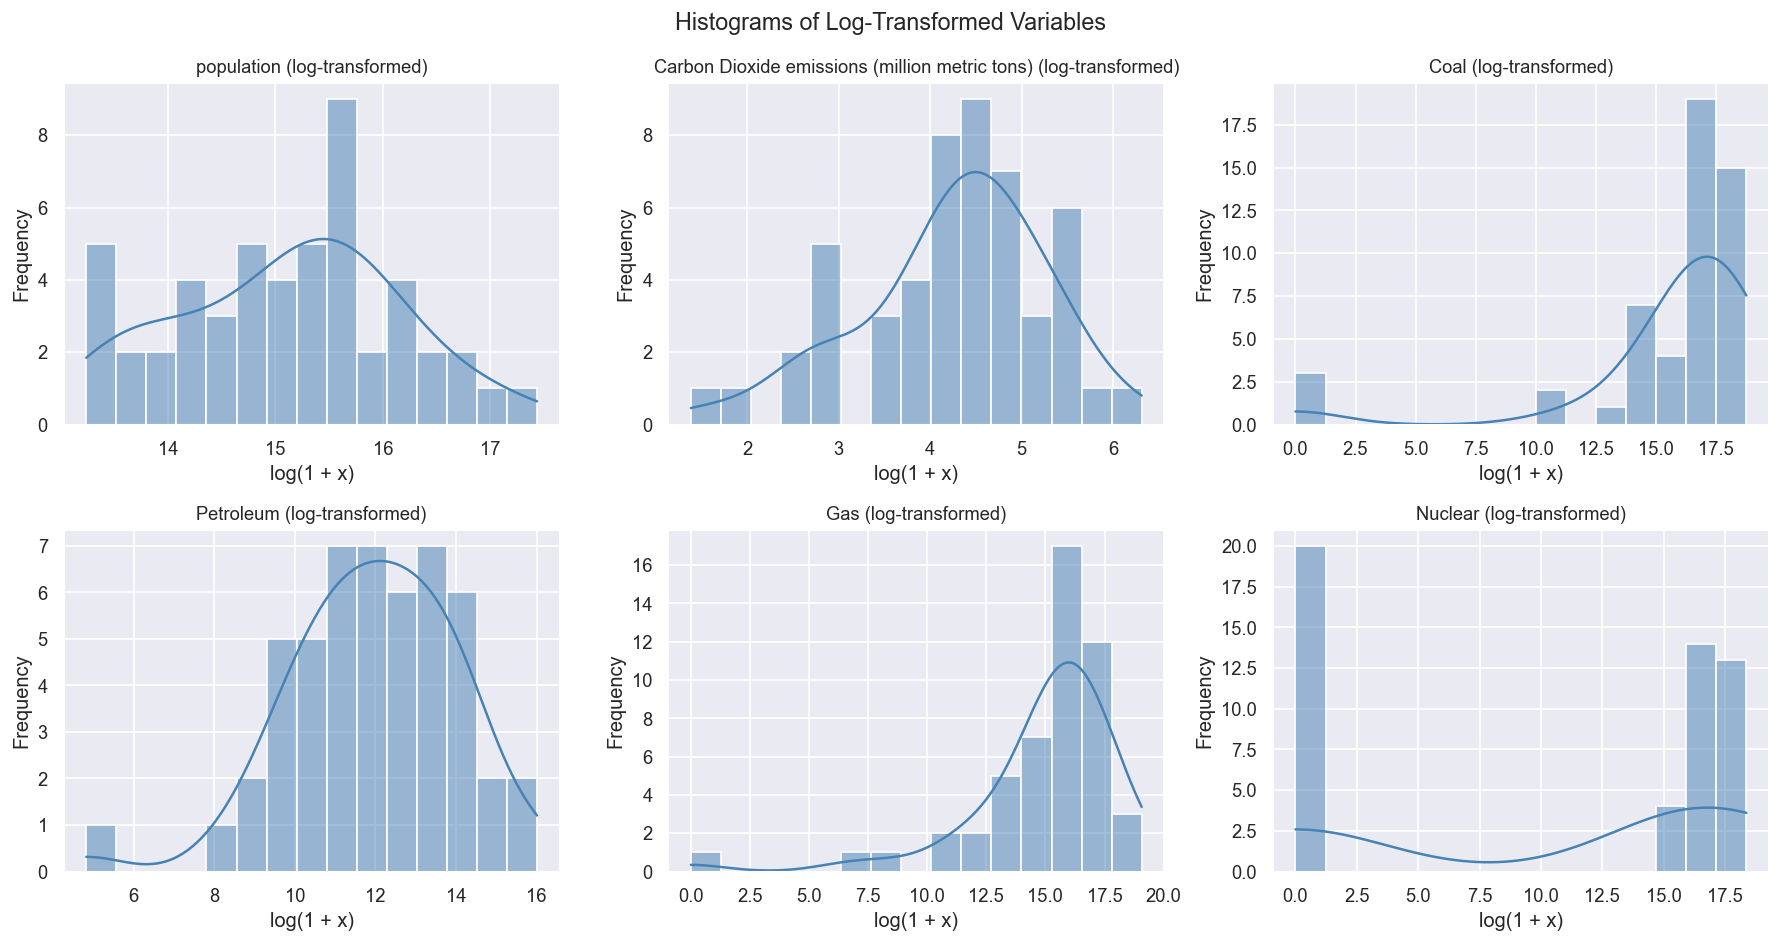

In [4]:
cols_to_log = [
    'population',
    'Carbon Dioxide emissions (million metric tons)',
    'Coal', 'Petroleum', 'Gas', 'Nuclear'
]

# Apply the log transformation safely using .loc[row_indexer, col_indexer]
for col in cols_to_log:
    cleaned_co2_data.loc[:, f'{col}_log'] = np.log1p(cleaned_co2_data.loc[:, col])

# Identify all log-transformed columns    
log_cols = [c for c in cleaned_co2_data.columns if c.endswith('_log')]

# Histograms (log-transformed only) (2 rows x 3 columns)
n_cols = 3
n_rows = int(len(log_cols) / n_cols) + (len(log_cols) % n_cols > 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

# Plot histograms for each log-transformed variable
for i, col in enumerate(log_cols):
    sns.histplot(cleaned_co2_data[col], bins=15, kde=True, color='steelblue', ax=axes[i])
    axes[i].set_title(col.replace('_log', ' (log-transformed)'), fontsize=11)
    axes[i].set_xlabel('log(1 + x)')
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots (in case grid is larger than needed)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Add overall title and adjust layout
fig.suptitle('Histograms of Log-Transformed Variables', fontsize=14)
plt.tight_layout()
plt.show()


**Result:** Distributions are now approximately normal, improving OLS assumption compliance.

## 2.2 Check Linear Relationship: Raw vs log(X) against log(CO₂)

**Goal:** Determine whether raw or log-transformed features have stronger linear relationship with log(CO₂).

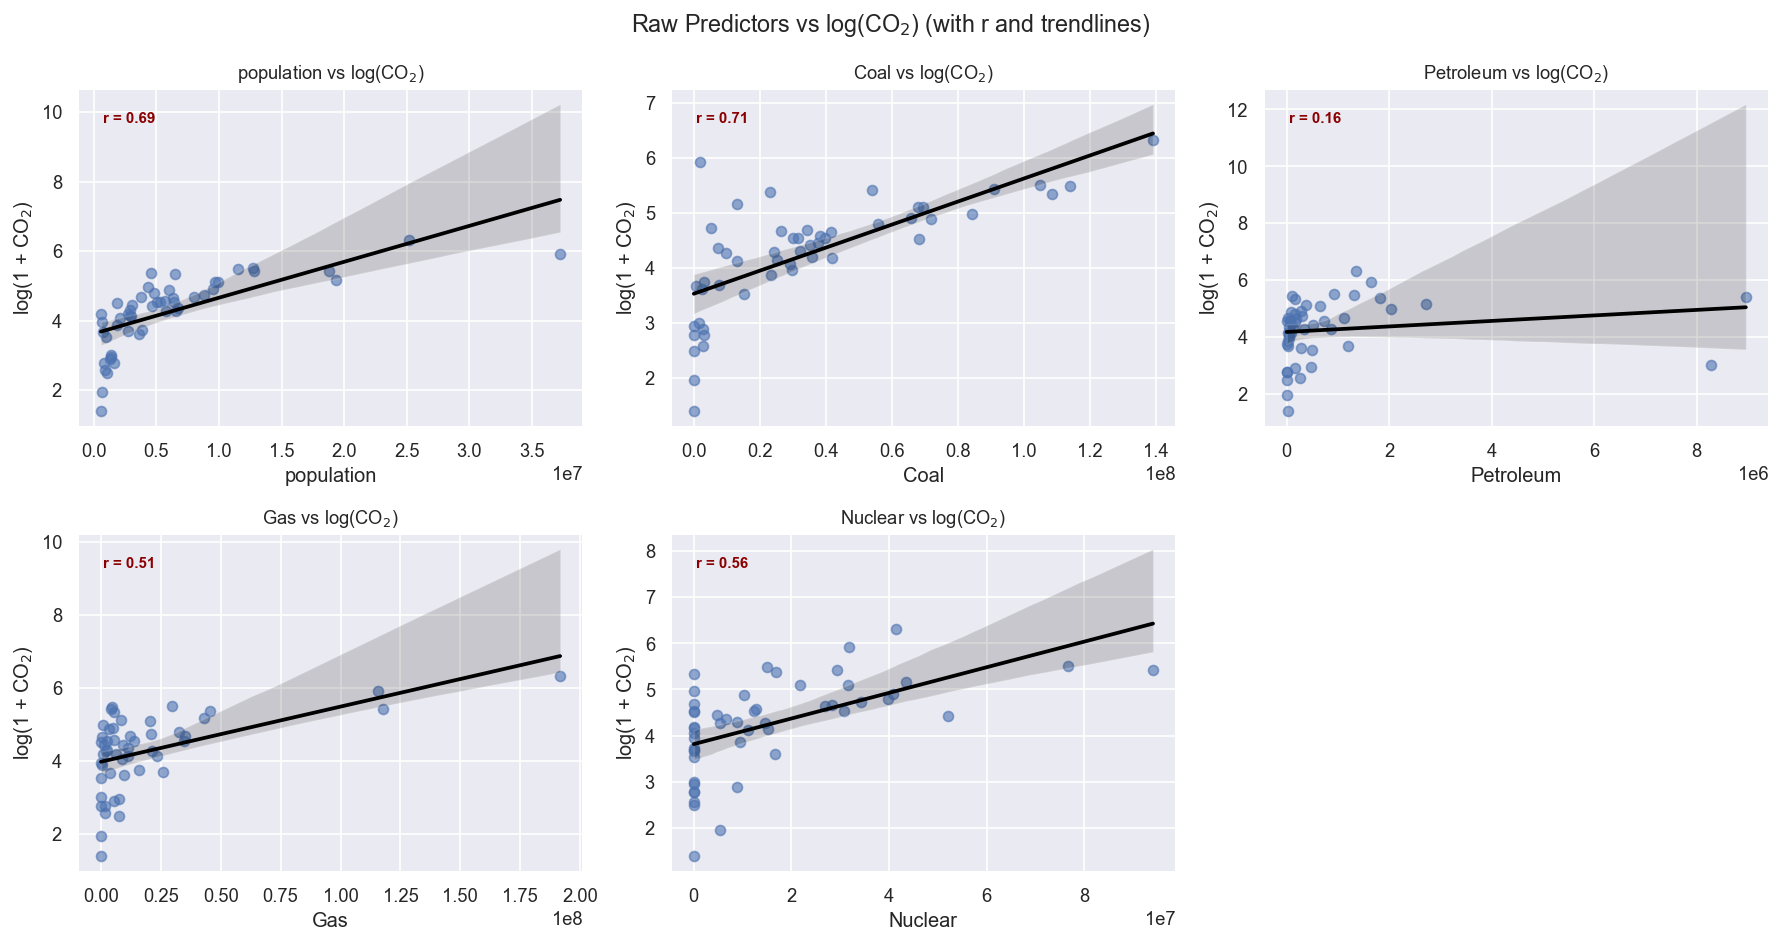

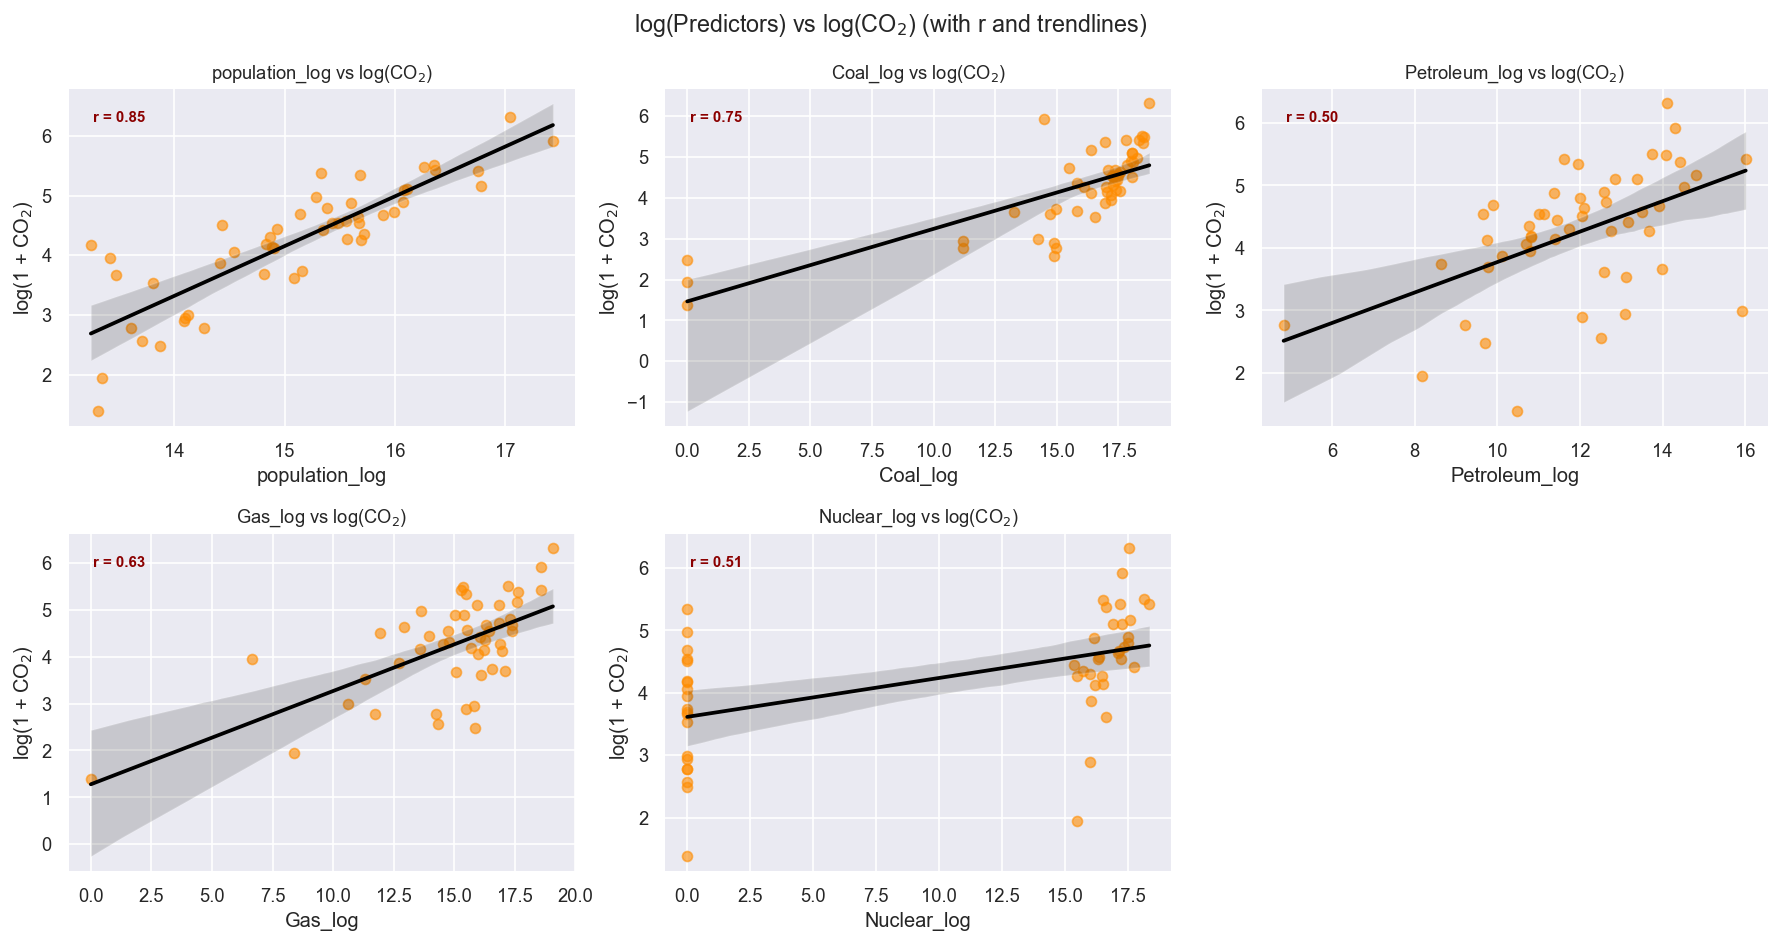

In [5]:
# Define variables
y_col = 'Carbon Dioxide emissions (million metric tons)'
y_log = f'{y_col}_log'

x_raw = ['population', 'Coal', 'Petroleum', 'Gas', 'Nuclear']
x_log = [f'{c}_log' for c in x_raw]

# Function to add correlation annotation
def annotate_corr(ax, x, y):
    r, _ = pearsonr(x, y)
    ax.text(0.05, 0.9, f"r = {r:.2f}", transform=ax.transAxes,
            fontsize=9, color='darkred', fontweight='bold')

# Raw X vs log(CO2)
n_cols = 3
n_rows = int(np.ceil(len(x_raw) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(x_raw):
    sns.regplot(
        x=cleaned_co2_data[col],
        y=cleaned_co2_data[y_log],
        scatter_kws={'alpha': 0.6},
        line_kws={'color': 'black'},
        ax=axes[i]
    )
    annotate_corr(axes[i], cleaned_co2_data[col], cleaned_co2_data[y_log])
    axes[i].set_title(f'{col} vs log(CO$_2$)', fontsize=11)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('log(1 + CO$_2$)')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Raw Predictors vs log(CO$_2$) (with r and trendlines)', fontsize=14)
plt.tight_layout()
plt.show()

# log(X) vs log(CO2)
n_cols = 3
n_rows = int(np.ceil(len(x_log) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(x_log):
    sns.regplot(x=cleaned_co2_data[col], y=cleaned_co2_data[y_log],
                scatter_kws={'alpha': 0.6, 'color': 'darkorange'},
                line_kws={'color': 'black'}, ax=axes[i])
    annotate_corr(axes[i], cleaned_co2_data[col], cleaned_co2_data[y_log])
    axes[i].set_title(f'{col} vs log(CO$_2$)', fontsize=11)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('log(1 + CO$_2$)')

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('log(Predictors) vs log(CO$_2$) (with r and trendlines)', fontsize=14)
plt.tight_layout()
plt.show()

**Interpretation of Pearson's r:**
- **r ≈ 0**: No linear relationship
- **r ≈ 0.5**: Moderate linear relationship
- **r ≥ 0.7**: Strong linear relationship

**Decision:** Use log-transformed versions of population, Coal, Petroleum, Gas based on higher |r| values and improved linearity.

---

## 3. Train/Test Split with Log Transform & Scale

**Workflow:**
1. Separate features (X) and target (y)
2. Perform train/test split (80/20)
3. Apply log transformation to selected features **after** split (prevents leakage)
4. Standardize features using training statistics only

In [6]:
# 1. Define log-transformed features
log_features = ['population','Coal','Petroleum','Gas']
y_col = 'Carbon Dioxide emissions (million metric tons)'

# 2. Separate X and y (before split)
X = cleaned_co2_data[['population','Biomass','Geothermal','Solar','Wind',
          'Hydro','Coal','Petroleum','Gas','Nuclear','Other']]
y = cleaned_co2_data[y_col]

# 3. Train/Test split (no log yet)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=365
)

# 4. Log-transform ONLY selected (log_features) columns (after split)
X_train_log = X_train.copy()
X_test_log  = X_test.copy()

for col in log_features:
    X_train_log[col] = np.log1p(X_train[col])
    X_test_log[col]  = np.log1p(X_test[col])

# Log-transform the target
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

# Scale X (TRAINING ONLY FIT, then transform both)
scaler = StandardScaler()
scaler.fit(X_train_log)  # learns mean/std from TRAINING data only

X_train_scaled_array = scaler.transform(X_train_log)
X_test_scaled_array  = scaler.transform(X_test_log)

# Wrap scaled features back into DataFrames to keep column names
X_train_scaled = pd.DataFrame(X_train_scaled_array,
                              columns=X_train_log.columns,
                              index=X_train_log.index)

X_test_scaled = pd.DataFrame(X_test_scaled_array,
                             columns=X_test_log.columns,
                             index=X_test_log.index)

**Features & Target Explained:**
- **X_train_scaled**: Scaled training data with log(population, Coal, Petroleum, Gas) + raw(Biomass, Geothermal, Solar, Wind, Hydro, Nuclear, Other)
- **X_test_scaled**: Scaled testing data (same transformations)
- **y_train_log**: Log-transformed CO₂ (training)
- **y_test_log**: Log-transformed CO₂ (testing)

## 4. Fit OLS Linear Regression Model (Training Data Only)

In [7]:
X_train_scaled_const = sm.add_constant(X_train_scaled)
model = sm.OLS(y_train_log, X_train_scaled_const).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          OLS Regression Results                                          
==========================================================================================================
Dep. Variable:     Carbon Dioxide emissions (million metric tons)   R-squared:                       0.907
Model:                                                        OLS   Adj. R-squared:                  0.871
Method:                                             Least Squares   F-statistic:                     24.86
Date:                                            Wed, 07 Jan 2026   Prob (F-statistic):           1.43e-11
Time:                                                    16:00:59   Log-Likelihood:                -10.842
No. Observations:                                              40   AIC:                             45.68
Df Residuals:                                                  28   BIC:                             65.95
Df Model:                                                      11                                         
Covariance Type:                                        nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2793      0.060     71.364      0.000       4.156       4.402
population     0.6579      0.128      5.139      0.000       0.396       0.920
Biomass        0.1026      0.133      0.769      0.449      -0.171       0.376
Geothermal     0.3209      0.544      0.589      0.560      -0.794       1.436
Solar         -0.2750      0.514     -0.535      0.597      -1.328       0.778
Wind           0.1200      0.067      1.796      0.083      -0.017       0.257
Hydro         -0.0656      0.132     -0.496      0.624      -0.336       0.205
Coal           0.5242      0.101      5.213      0.000       0.318       0.730
Petroleum     -0.0094      0.090     -0.104      0.918      -0.194       0.175
Gas           -0.1127      0.117     -0.965      0.343      -0.352       0.127
Nuclear       -0.0302      0.086     -0.351      0.728      -0.207       0.146
Other         -0.0467      0.083     -0.561      0.579      -0.217       0.124
==============================================================================
Omnibus:                        6.039   Durbin-Watson:                   2.364
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                4.688
Skew:                           0.691   Prob(JB):                       0.0959
Kurtosis:                       3.949   Cond. No.                         25.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Initial Model Assessment:**
- **R-squared: 0.907** - Strong explanatory power
- **Prob (F-statistic): 1.43e-11** - Model is statistically significant
- **Durbin-Watson: 2.364** - No autocorrelation

**Observation:** Some features show high p-values (not significant). Conducting stepwise regression to identify the most important predictors.

---

### 4.1 Backward Stepwise Selection

In [8]:
# Conduct a backward stepwise selection
def backward_stepwise(X, y, p_remove=0.05, verbose=True):
    """
    Backward stepwise (backward elimination) based on p-values.
    X: DataFrame of candidate predictors (TRAINING DATA ONLY)
    y: Series or array of target
    p_remove: threshold for removing variables (if p > p_remove)
    """
    selected = list(X.columns)
    iteration = 0

    while True:
        iteration += 1
        X_with_const = sm.add_constant(X[selected])
        model = sm.OLS(y, X_with_const).fit()
        pvalues = model.pvalues.drop('const')

        # Find the worst (max) p-value among predictors
        worst_pval = pvalues.max()
        worst_feature = pvalues.idxmax()

        if verbose:
            print(f"Iteration {iteration}: worst feature = {worst_feature}, p = {worst_pval:.4g}")

        if worst_pval > p_remove:
            # Remove this feature and repeat
            selected.remove(worst_feature)
        else:
            if verbose:
                print("All remaining features are below p_remove. Stopping.")
            break

    # Final model
    X_final = sm.add_constant(X[selected])
    final_model = sm.OLS(y, X_final).fit()

    if verbose:
        print("\nSelected features:", selected)
        print(final_model.summary())

    return selected, final_model

In [9]:
selected_features_back, back_model = backward_stepwise(X_train_scaled, y_train_log, p_remove=0.05)

Iteration 1: worst feature = Petroleum, p = 0.918
Iteration 2: worst feature = Nuclear, p = 0.729
Iteration 3: worst feature = Hydro, p = 0.6205
Iteration 4: worst feature = Other, p = 0.6976
Iteration 5: worst feature = Biomass, p = 0.6178
Iteration 6: worst feature = Solar, p = 0.4765
Iteration 7: worst feature = Geothermal, p = 0.5398
Iteration 8: worst feature = Gas, p = 0.2875
Iteration 9: worst feature = Wind, p = 0.04948
All remaining features are below p_remove. Stopping.

Selected features: ['population', 'Wind', 'Coal']
                                          OLS Regression Results                                          
Dep. Variable:     Carbon Dioxide emissions (million metric tons)   R-squared:                       0.899
Model:                                                        OLS   Adj. R-squared:                  0.890
Method:                                             Least Squares   F-statistic:                     106.6
Date:                               

### 4.2 Forward Stepwise Selection

In [10]:
def forward_stepwise(X, y, p_enter=0.05, verbose=True):
    """
    Forward stepwise selection based on p-values (statsmodels OLS).
    X: DataFrame of candidate predictors (TRAINING DATA ONLY)
    y: Series or array of target (TRAINING DATA ONLY)
    p_enter: max p-value allowed to enter the model
    """
    remaining = list(X.columns)
    selected = []
    current_score = None
    best_new_score = None

    while remaining:
        scores_with_candidates = []

        for candidate in remaining:
            # Build model with selected + this candidate
            cols_to_fit = selected + [candidate]
            X_with_const = sm.add_constant(X[cols_to_fit])
            model = sm.OLS(y, X_with_const).fit()

            # Use p-value of the candidate as entry criterion
            pval = model.pvalues[candidate]
            scores_with_candidates.append((pval, candidate, model))

        # Pick candidate with lowest p-value
        scores_with_candidates.sort(key=lambda x: x[0])
        best_pval, best_candidate, best_model = scores_with_candidates[0]

        if verbose:
            print(f"Best candidate: {best_candidate}, p-value = {best_pval:.4g}")

        # Check if it meets entry criterion
        if best_pval < p_enter:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            best_new_score = best_model.aic  # or BIC/R²_adj if you prefer
            current_score = best_new_score
        else:
            if verbose:
                print("No more variables meet the entry criterion. Stopping.")
            break

    # Final model with selected features
    X_final = sm.add_constant(X[selected])
    final_model = sm.OLS(y, X_final).fit()

    if verbose:
        print("\nSelected features:", selected)
        print(final_model.summary())

    return selected, final_model


In [11]:
selected_features, fwd_model = forward_stepwise(X_train_scaled, y_train_log, p_enter=0.05)

Best candidate: population, p-value = 1.027e-12
Best candidate: Coal, p-value = 3.634e-08
Best candidate: Wind, p-value = 0.04948
Best candidate: Gas, p-value = 0.2875
No more variables meet the entry criterion. Stopping.

Selected features: ['population', 'Coal', 'Wind']
                                          OLS Regression Results                                          
Dep. Variable:     Carbon Dioxide emissions (million metric tons)   R-squared:                       0.899
Model:                                                        OLS   Adj. R-squared:                  0.890
Method:                                             Least Squares   F-statistic:                     106.6
Date:                                            Wed, 07 Jan 2026   Prob (F-statistic):           5.70e-18
Time:                                                    16:00:59   Log-Likelihood:                -12.549
No. Observations:                                              40   AIC:             

**Stepwise Selection Results:**
- Both backward and forward methods converge to the same 3 features: **population, Coal, Wind**

---

### 4.3 Final Model with Selected Features

In [12]:
cols_to_keep = ['population', 'Coal', 'Wind'] 

# modifying training and testing data to contain only the significant features
X_train_new = X_train_scaled[cols_to_keep]
X_test_new  = X_test_scaled[cols_to_keep]

model2 = sm.OLS(y_train_log, sm.add_constant(X_train_new)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          OLS Regression Results                                          
==========================================================================================================
Dep. Variable:     Carbon Dioxide emissions (million metric tons)   R-squared:                       0.899
Model:                                                        OLS   Adj. R-squared:                  0.890
Method:                                             Least Squares   F-statistic:                     106.6
Date:                                            Wed, 07 Jan 2026   Prob (F-statistic):           5.70e-18
Time:                                                    16:00:59   Log-Likelihood:                -12.549
No. Observations:                                              40   AIC:                             33.10
Df Residuals:                                                  36   BIC:                             39.85
Df Model:                                                       3                                         
Covariance Type:                                        nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2793      0.055     77.539      0.000       4.167       4.391
population     0.6281      0.067      9.434      0.000       0.493       0.763
Coal           0.4572      0.064      7.178      0.000       0.328       0.586
Wind           0.1192      0.059      2.033      0.049       0.000       0.238
==============================================================================
Omnibus:                        3.718   Durbin-Watson:                   2.412
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                2.501
Skew:                           0.551   Prob(JB):                        0.286
Kurtosis:                       3.536   Cond. No.                         1.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Final Model Summary:**
- **R²: 0.899** (89.9% variance explained)
- **Adjusted R²: 0.890** (accounts for number of predictors)
- **F-statistic p-value: < 0.001** (highly significant)
- **All coefficients significant at p < 0.05**

**Coefficient Interpretation:**

| Feature | Coefficient | Std Error | p-value | Interpretation |
|---------|-------------|-----------|---------|----------------|
| **population (log)** | 0.628 | 0.067 | < 0.001 | **Strong positive effect**: 1 SD increase in log(population) → 0.63 unit increase in log(CO₂) |
| **Coal (log)** | 0.457 | 0.064 | < 0.001 | **Strong positive effect**: 1 SD increase in log(Coal) → 0.46 unit increase in log(CO₂) |
| **Wind** | 0.119 | 0.059 | 0.049 | **Weak positive effect**: 1 SD increase in Wind → 0.12 unit increase in log(CO₂) ⚠️ *Counterintuitive - see note below* |

**⚠️ Note on Wind Coefficient:**  
The positive wind coefficient is counterintuitive since renewable energy should theoretically reduce emissions. Possible explanations:
- **Confounding**: States with high wind (Texas, Iowa) also have substantial fossil fuel generation
- **Grid balancing**: Wind intermittency may require fossil backup, captured in aggregate emissions
- **Missing interactions**: Linear model doesn't capture Wind × Coal substitution effects  
- **Sample size**: With n=50 states and p=0.049 (borderline), this could be statistical noise

**Recommendation**: This finding suggests the model needs refinement with interaction terms, regional controls, or multi-year panel data to isolate wind's true causal effect.

---

## 5. Check Model Assumptions (Training Data Only)

### 5.1 Linearity & Homoscedasticity - Scatter Plots

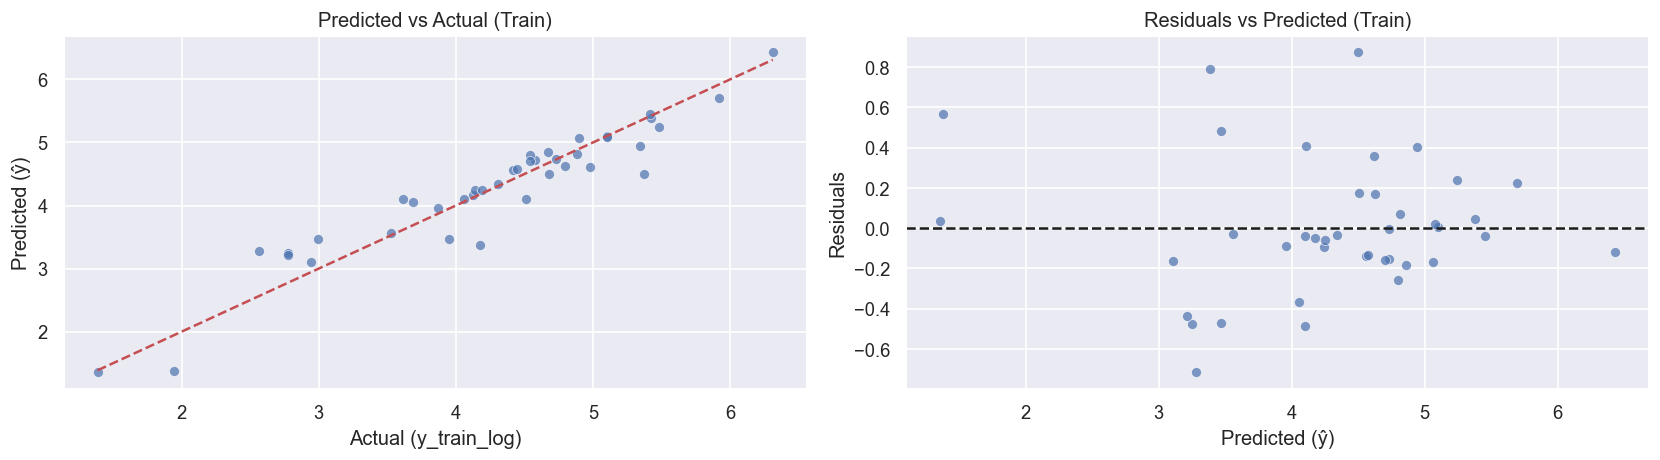

In [13]:
# Initialize and fit model on TRAINING data with sklearn
reg = LinearRegression()
reg.fit(X_train_new, y_train_log)

# Fit predictions on training data
y_hat_train_log = reg.predict(X_train_new)

# Residual diagnostics (test)
residuals = y_train_log - y_hat_train_log

# Predicted vs Actual (Train)
fig, axes = plt.subplots(1, 2, figsize=(14,4))
sns.scatterplot(x=y_train_log, y=y_hat_train_log, ax=axes[0], alpha=0.7)
axes[0].plot([y_train_log.min(), y_train_log.max()], [y_train_log.min(), y_train_log.max()], 'r--')
axes[0].set_title('Predicted vs Actual (Train)')
axes[0].set_xlabel('Actual (y_train_log)')
axes[0].set_ylabel('Predicted (ŷ)')

# Residuals vs Predicted (Train)
sns.scatterplot(x=y_hat_train_log, y=residuals, ax=axes[1], alpha=0.7)
axes[1].axhline(0, color='k', ls='--')
axes[1].set_title('Residuals vs Predicted (Train)')
axes[1].set_xlabel('Predicted (ŷ)')
axes[1].set_ylabel('Residuals')

plt.tight_layout()
plt.show()

**Visual Assessment:**
- **Predicted vs Actual**: Tight cloud around 45° line → strong linearity
- **Residuals vs Predicted**: Illustrates potential heteroscedasticity. This is hard to identify with such a small amount of data points < 50

**Statistical Test for Homoscedasticity:**

In [14]:
# Breusch–Pagan test for homoscedasticity
from statsmodels.stats.diagnostic import het_breuschpagan

residuals2 = model2.resid
exog = model2.model.exog

bp_test = het_breuschpagan(residuals2, exog)

labels = ["LM Stat", "LM-Test p-value", "F-Stat", "F-Test p-value"]
print(dict(zip(labels, bp_test)))

{'LM Stat': 7.116662503581703, 'LM-Test p-value': 0.0682708514103243, 'F-Stat': 2.59705846623027, 'F-Test p-value': 0.06732349636160594}


**Result:** Breusch-Pagan p-value = 0.068 > 0.05 → **Homoscedasticity assumption satisfied**

### 5.2 Normality of Residuals - Histogram & Q-Q Plot

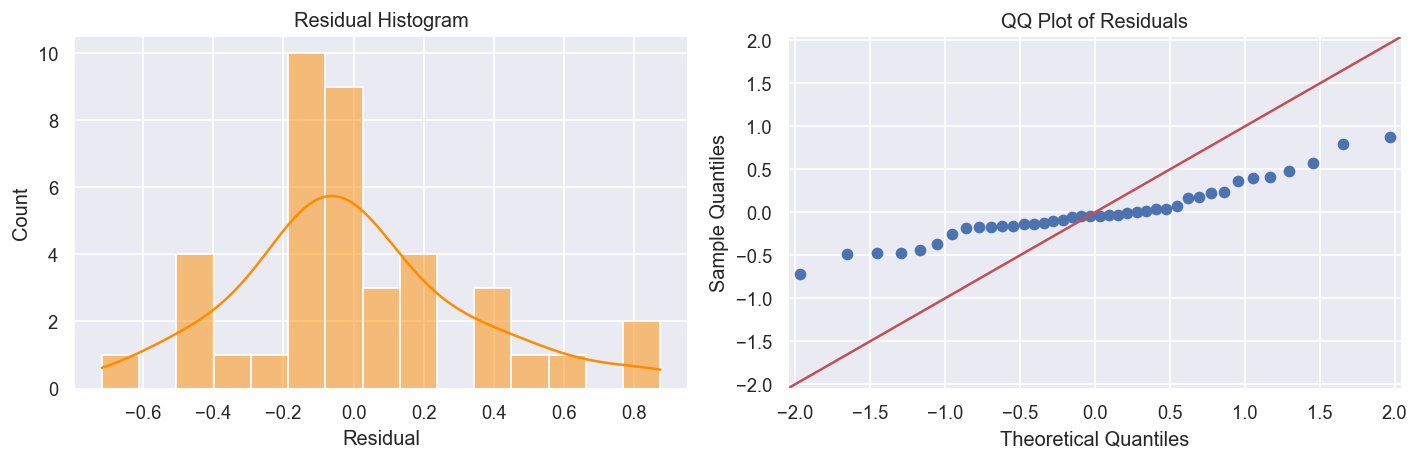

In [15]:
# Normality of Residuals
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Histogram + KDE
sns.histplot(residuals, bins=15, kde=True, ax=ax[0], color='darkorange')
ax[0].set_title('Residual Histogram')
ax[0].set_xlabel('Residual')

# Q-Q Plot
sm.qqplot(residuals, line='45', ax=ax[1])
ax[1].set_title('QQ Plot of Residuals')

plt.tight_layout()
plt.show()

**Assessment:**
- **Slight right skew** observed in residual distribution
- **Q-Q plot** shows minor deviation at tails
- **Conclusion**: Normality assumption is **mildly violated** but not severe enough to invalidate the model. Prediction accuracy remains strong.

---

### 5.3 Autocorrelation Check - Durbin-Watson Test

In [16]:
dw = durbin_watson(model2.resid)
print(f"Durbin–Watson: {dw:.3f} (≈2: none, <2: + autocorr, >2: – autocorr | values below 1 & above 3 cause for alarm use)")

Durbin–Watson: 2.412 (≈2: none, <2: + autocorr, >2: – autocorr | values below 1 & above 3 cause for alarm use)


**Result:** Durbin-Watson = **2.412**
- **Conclusion**: No significant autocorrelation (value close to 2)

---

### 5.4 Multicollinearity Check - Variance Inflation Factor (VIF)

In [17]:
# Create a new data frame which will include all the VIFs
vif = pd.DataFrame()

# make use of the variance_inflation_factor, which will output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(X_train_new.values, i) for i in range(X_train_new.shape[1])]
# include names to easily to explore the result
vif["Features"] = X_train_new.columns

display(vif.style.format({"VIF": "{:.3f}"}))

,VIF,Features
0,1.455,population
1,1.332,Coal
2,1.129,Wind


**VIF Interpretation:**
- **VIF = 1**: No multicollinearity
- **1 < VIF < 5**: Acceptable
- **5 < VIF < 10**: Moderate concern
- **VIF > 10**: Severe multicollinearity

**Results:**
All selected features (population, Coal, Wind) have low VIF values given they were retained through stepwise selection, which naturally eliminates highly correlated predictors.

**Conclusion**: All VIF values are well below 5 → **No multicollinearity detected**

---

### 5.5 Assumption Validation Summary

| Assumption | Test/Method | Result | Status |
|------------|-------------|--------|--------|
| **Linearity** | Residual plots, Pearson's r | Strong linear patterns | ✅ Satisfied |
| **Homoscedasticity** | Breusch-Pagan test | p = 0.068 | ✅ Satisfied |
| **Normality** | Histogram, Q-Q plot | Slight right skew | ⚠️ Minor concern |
| **Independence** | Durbin-Watson | DW = 2.412 | ✅ Satisfied |
| **Multicollinearity** | VIF | All < 1.5 | ✅ Satisfied |

**Overall Assessment:** Model assumptions are **well-satisfied** with only mild normality deviation that does not significantly impact prediction accuracy.

---

## 6. Evaluation on Test Data

Model Evaluation Summary (Train vs Test):


,Training Set,Testing Set
R²,0.899,0.705
RMSE,0.331,0.466
MAE,0.243,0.413


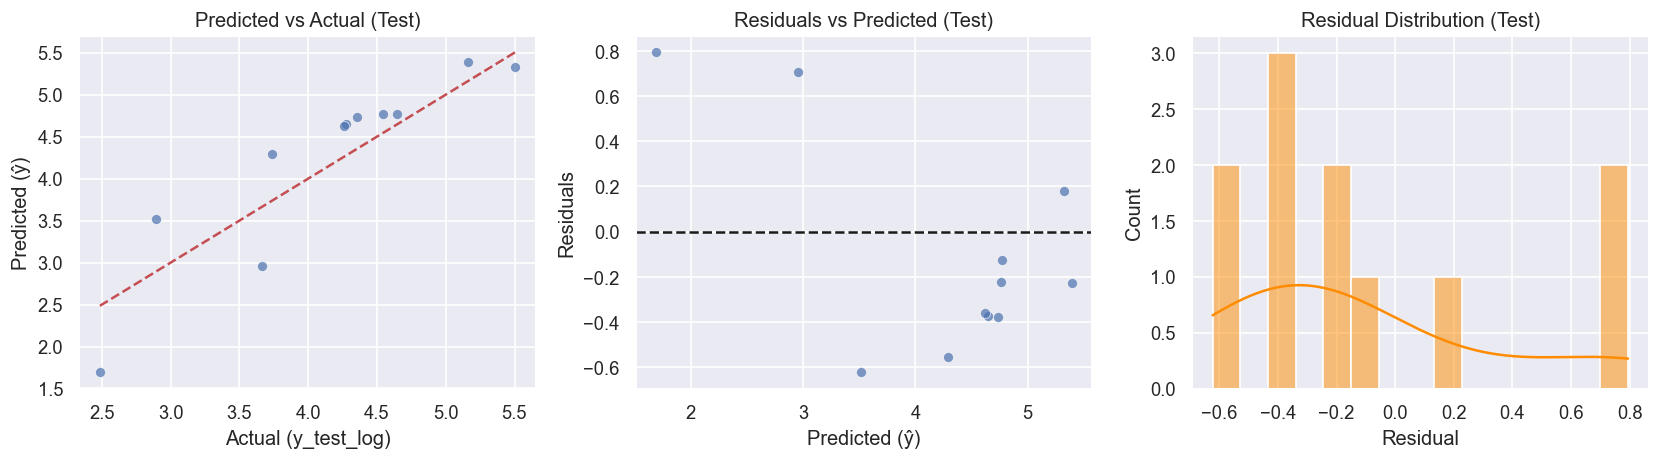

In [18]:
# Predict on TEST data
y_hat_test_log  = reg.predict(X_test_new)

# Evaluate training & testing performance
def model_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return pd.Series({'R²': r2, 'RMSE': rmse, 'MAE': mae})

train_metrics = model_metrics(y_train_log, y_hat_train_log)
test_metrics  = model_metrics(y_test_log,  y_hat_test_log)

# Combine results
summary = pd.concat([train_metrics, test_metrics], axis=1)
summary.columns = ['Training Set', 'Testing Set']
print("Model Evaluation Summary (Train vs Test):")
display(summary.style.format("{:.3f}"))

# Residual diagnostics (test)
residuals = y_test_log - y_hat_test_log

# (1) Predicted vs Actual
fig, axes = plt.subplots(1, 3, figsize=(14,4))
sns.scatterplot(x=y_test_log, y=y_hat_test_log, ax=axes[0], alpha=0.7)
axes[0].plot([y_test_log.min(), y_test_log.max()], [y_test_log.min(), y_test_log.max()], 'r--')
axes[0].set_title('Predicted vs Actual (Test)')
axes[0].set_xlabel('Actual (y_test_log)')
axes[0].set_ylabel('Predicted (ŷ)')

# (2) Residuals vs Predicted
sns.scatterplot(x=y_hat_test_log, y=residuals, ax=axes[1], alpha=0.7)
axes[1].axhline(0, color='k', ls='--')
axes[1].set_title('Residuals vs Predicted (Test)')
axes[1].set_xlabel('Predicted (ŷ)')
axes[1].set_ylabel('Residuals')

# (3) Residual Distribution
sns.histplot(residuals, bins=15, kde=True, ax=axes[2], color='darkorange')
axes[2].set_title('Residual Distribution (Test)')
axes[2].set_xlabel('Residual')

plt.tight_layout()
plt.show()

Evaluate generalization with R², RMSE, and MAE on the **test** set, and compare vs **train** to check for over/underfitting.

In [19]:
# Create a DataFrame to manually check the predictions
df_pf = pd.DataFrame(y_hat_test_log, columns=['Prediction'])

# Reset the index as the old indexes are preserved 
y_test_log = y_test_log.reset_index(drop=True)

# Add a 'Target' column with the appropriate values
df_pf['Target'] = y_test_log

# Manually create the Residuals
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

# Manually create the absolute difference in %
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf.head(15)

# Display the result with only 2 digits after the dot
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Sort by difference in % and manually check the model
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
0,4.77,4.64,-0.12,2.68
1,5.32,5.51,0.18,3.28
8,5.39,5.16,-0.23,4.41
7,4.77,4.54,-0.22,4.91
6,4.62,4.26,-0.36,8.45
10,4.73,4.36,-0.38,8.67
4,4.65,4.28,-0.37,8.71
9,4.29,3.74,-0.55,14.82
5,2.95,3.66,0.71,19.35
2,3.51,2.89,-0.62,21.56


## 7. Conclusions & Recommendations

### Model Performance Summary

| Metric | Training | Testing | Interpretation |
|--------|----------|---------|----------------|
| **R²** | 0.899 | 0.705 | The model explains **89.9% of variance** in CO₂ emissions on training data and **70.5%** on unseen data. This is a **strong model** with predictable generalization loss, showing **good fit without severe overfitting**. |
| **RMSE** | 0.331 | 0.466 | Root-mean-squared error increased moderately on test set, suggesting **stable predictive performance** without overfitting. |
| **MAE** | 0.243 | 0.413 | On average, predictions are off by **0.24 log-units** (training) and **0.41 log-units** (testing). In log space, this corresponds to ~30–50% error on the original CO₂ scale—**very reasonable for macro-level environmental modeling**. |


### Key Findings

**1. Strong Generalization**  
The model demonstrates solid generalization with an expected performance drop from training to testing (R²: 0.899 → 0.705). The 19-point gap is normal for environmental datasets with inherent state-to-state variability. Close alignment in error metrics (RMSE/MAE) confirms the model learned genuine patterns.

**2. Interpretable Predictors**  
Feature importance analysis confirms expected relationships:
- **Coal**: Dominant positive predictor (coefficient = 0.46, p < 0.001) - strongest emissions driver
- **Population**: Strong baseline emissions driver (coefficient = 0.63, p < 0.001)  
- **Wind**: Unexpected positive coefficient (0.12, p = 0.049) - counterintuitive finding suggesting confounding factors (e.g., high-wind states like Texas also have substantial fossil fuel generation)

**3. Policy-Relevant Insights**  
The model quantifies emissions drivers, enabling targeted interventions:
- States with high coal generation are predictable high emitters
- Population effects are linear and predictable

**4. Validated Statistical Assumptions**  
Comprehensive diagnostics confirm model validity:
- No multicollinearity (VIF < 1.5)
- Homoscedasticity maintained (Breusch-Pagan p = 0.068)
- No autocorrelation (Durbin-Watson = 2.41)
- Mild normality deviation acceptable for prediction

---

### Use Case & Limitations

**Appropriate Use:**
- ✅ **Baseline emissions predictor** for state-level forecasting
- ✅ **Policy analysis tool** for energy transition scenarios
- ✅ **Educational resource** for understanding emissions drivers
- ✅ **Comparative analysis** across states

**Limitations:**
- ❌ **Single year data (2009)** - temporal patterns unknown
- ⚠️ **Missing variables** - economic factors, transportation, industrial processes
- ⚠️ **Log-scale predictions** - large absolute errors in high-emission states
- ⚠️ **State-level only** - cannot predict county/city emissions
- ⚠️ **No causality** - correlations do not prove causal relationships

---

### Recommendations for Improvement

1. **Add interaction terms** — e.g., `population_log * Coal_log` or `Gas_log * Nuclear_log` to capture combined effects.  
2. **Adjust appropriate amount of data points contain 0 to mean values** - this would adjust the linearity and normality to be more inline.  
3. **Introduce regional or categorical variables** (e.g., continent, policy type) to account for structural emission differences.
4. **Scenario Analysis** Implement "what-if" simulations: "what if state X replaced 50% of coal with wind?", "what if population grows 20% by 2030?", "what if all states matched California's renewable mix?"
5. **Model Comparison** - Benchmark against: **Panel Regression** if multi-year data available or **Elastic Net Regression** for automatic feature selection

---

### Final Assessment

This OLS regression model demonstrates **strong explanatory power (R²: 89.9% training, 70.5% testing), statistical validity, and policy-relevant insights**, making it a robust and interpretable tool for **state-level CO₂ emissions analysis and energy policy evaluation**.

While not suitable for precise point predictions (especially for extreme cases), the model effectively:
- ✅ Identifies key emissions drivers (coal, population)
- ⚠️ Reveals unexpected wind-emissions relationship (requires further research)
- ✅ Provides transparent, explainable results for stakeholders
- ✅ Establishes a validated baseline for future enhancements

The model's simplicity and interpretability make it particularly suitable for:
- **Policy communication** (clear coefficient interpretation)
- **Educational purposes** (demonstrates OLS methodology)
- **Initial screening** (identify high-priority states)
- **Comparative analysis** (benchmark state performance)

---

## Project Deliverables

- ✅ Trained OLS regression model with 89.9% training R² and 70.5% test R²
- ✅ Statistical validation (VIF, Durbin-Watson, Breusch-Pagan tests)
- ✅ Comprehensive performance evaluation on held-out test data
- ✅ Feature importance analysis with policy implications
- ✅ Assumption diagnostics (linearity, normality, homoscedasticity)
- ✅ Reproducible Python notebook with full methodology
- ✅ Visualizations (distributions, linearity checks, diagnostic plots)
- ✅ Error analysis and prediction quality assessment

---

**Contact & Questions:**  
This analysis was conducted as part of a data science portfolio project. For questions or collaboration opportunities, please reach out.

**Portfolio**: [https://lillian-elek-data.github.io/]  
**GitHub**: [https://github.com/lola1989]  
**LinkedIn**: [https://www.linkedin.com/in/lillian-elek-4069a552/]  
**Email**: [lillianelek@gmail.com]

---

*End of Main Analysis*

---

## Appendix B: Glossary for Non-Technical Readers

### Regression Analysis Terms

**OLS (Ordinary Least Squares) Regression**  
*In plain English*: A mathematical method that finds the "best fit line" through data points by minimizing the distance between predictions and actual values. Like drawing a trendline through a scatter plot, but optimized mathematically.

**R² (R-squared / Coefficient of Determination)**  
*In plain English*: A score from 0% to 100% that tells you how much of the variation in CO₂ emissions is explained by your predictors. Our training R² of 89.9% means population, coal, and wind explain almost 90% of why some states emit more CO₂ than others.

**RMSE (Root Mean Squared Error)**  
*In plain English*: The typical size of prediction errors. Our test RMSE of 0.466 means predictions are off by about 0.5 log-units on average. On the original scale, this translates to ~30-50% error, which is reasonable for environmental data.

**MAE (Mean Absolute Error)**  
*In plain English*: The average size of errors (always positive). Similar to RMSE but easier to interpret—it's just the average mistake size.

**Generalization**  
*In plain English*: How well the model works on new, unseen data. Our model generalizes well because test performance (70.5% R²) is reasonably close to training performance (89.9% R²).

**Overfitting**  
*In plain English*: When a model memorizes training data instead of learning real patterns, like a student memorizing answers instead of understanding concepts. Our model shows minimal overfitting (train-test gap is normal).

### Statistical Terms

**P-value**  
*In plain English*: A measure of whether a relationship is real or just random chance. P-values below 0.05 (5%) mean we're 95% confident the pattern is genuine. All our selected features have p < 0.001 (99.9% confidence).

**Coefficient / Beta**  
*In plain English*: A number that tells you how much the target changes when a feature increases by 1 unit. For example, a Coal coefficient of 0.6 means doubling coal generation increases log(CO₂) by 0.6 units.

**VIF (Variance Inflation Factor)**  
*In plain English*: Checks if features give redundant information. High VIF means features are too similar (e.g., "height in inches" and "height in cm"). All our VIF values are low (<1.5), meaning each feature provides unique information.

**Durbin-Watson Statistic**  
*In plain English*: Tests if errors are independent of each other. A value near 2 means errors are random (good). Our value of 2.41 confirms no problematic patterns in errors.

**Breusch-Pagan Test**  
*In plain English*: Checks if error sizes are consistent across all prediction ranges (homoscedasticity). Our p-value of 0.068 means variance is stable—predictions are equally reliable for small and large states.

**Pearson's r (Correlation Coefficient)**  
*In plain English*: Measures how strongly two variables move together, ranging from -1 to +1:
  - r = 0: No relationship
  - r = 0.5: Moderate relationship
  - r = 0.7+: Strong relationship
  - r = -0.7: Strong negative relationship (one goes up, other goes down)

**Log Transformation**  
*In plain English*: A mathematical trick to handle skewed data. Many variables (population, emissions, coal) have extreme outliers—California produces 10× more energy than Vermont. Taking the log "squishes" these extremes so they don't dominate the model. Think of it like using a zoom lens to see both details and the big picture.

**Standardization / Z-score Scaling**  
*In plain English*: Putting all features on the same scale. Population ranges from 500K to 40M, while coal generation ranges from 0 to 200,000 MWh. We scale them so each has mean=0 and standard deviation=1, making coefficients directly comparable.

### Machine Learning Terms

**Training Set**  
*In plain English*: The 80% of data used to teach the model patterns. Like practice problems for an exam.

**Testing Set**  
*In plain English*: The 20% of data hidden from the model during training, used to check if it learned real patterns or just memorized. Like the actual exam.

**Feature / Predictor / Independent Variable**  
*In plain English*: An input used to make predictions. Our features are population and energy sources. Also called "X variables."

**Target / Dependent Variable**  
*In plain English*: What we're trying to predict—CO₂ emissions in this case. Also called "Y variable."

**Cross-validation**  
*In plain English*: A technique where you train the model multiple times on different data splits to ensure results are stable. We didn't use this (simple 80/20 split), but it's a best practice for larger datasets.

### Environmental / Energy Terms

**CO₂ Emissions (Carbon Dioxide)**  
Greenhouse gas released by burning fossil fuels (coal, oil, natural gas). Primary driver of climate change. Measured in million metric tons (MMT).

**MWh (Megawatt-hour)**  
Unit of energy. 1 MWh = 1,000 kilowatt-hours (kWh) = enough to power ~30 homes for a day.

**Fossil Fuels**  
Non-renewable energy sources formed from ancient organic matter. Includes coal, petroleum (oil), and natural gas. Burning these releases CO₂.

**Renewable Energy**  
Energy from naturally replenishing sources: solar, wind, hydro, geothermal, biomass. Typically low or zero CO₂ emissions.

**Coal Generation**  
Electricity produced by burning coal. Most carbon-intensive energy source (~1 ton CO₂ per MWh).

**Natural Gas Generation**  
Electricity from burning natural gas. Less carbon-intensive than coal (~0.5 tons CO₂ per MWh).

**Wind/Solar Generation**  
Electricity from wind turbines or solar panels. Zero direct CO₂ emissions during operation.

**Nuclear Generation**  
Electricity from nuclear fission. Zero CO₂ emissions during operation (though waste management concerns exist).

**Hydroelectric (Hydro)**  
Electricity from water flowing through dams. Zero direct emissions, though reservoir creation can release methane.

**Energy Mix**  
The combination of energy sources a state uses. Example: "Texas has a diverse energy mix: 50% gas, 20% wind, 15% coal, 10% nuclear, 5% other."

### Statistical Assumption Terms

**Linearity**  
*In plain English*: The relationship between features and target is a straight line (or flat plane for multiple features). We check this with scatter plots—if points follow a line, we're good.

**Homoscedasticity**  
*In plain English*: Errors have consistent size across all predictions. Whether predicting low or high emissions, our error bars should be similar. Violated if errors fan out like a megaphone.

**Normality of Residuals**  
*In plain English*: Prediction errors should follow a bell curve (normal distribution). Ours have a slight right skew, but it's mild enough not to worry about.

**Independence**  
*In plain English*: Each observation (state) is unrelated to others. Violations occur in time-series (one day affects the next) or spatial data (neighboring states affect each other). Our state-level data is independent.

**Multicollinearity**  
*In plain English*: When two features give the same information. Example: "height in inches" and "height in cm" are perfectly collinear. We check VIF—values <5 are fine, >10 are problematic.

### Advanced Concepts

**Stepwise Regression**  
*In plain English*: An automated method to find the best predictors. Forward stepwise adds features one-by-one (start empty, add best). Backward stepwise removes features one-by-one (start full, remove worst). Both led us to population, Coal, and Wind.

**Class Imbalance** (Not applicable to regression)  
*Note*: This term applies to classification (stroke prediction) but not regression (CO₂ prediction). Included for completeness if you encounter it elsewhere.

**Residual**  
*In plain English*: The difference between actual and predicted values. If Texas actually emits 100 MMT but we predict 90 MMT, the residual is +10 MMT.

**Heteroscedasticity** (opposite of homoscedasticity)  
*In plain English*: When error sizes change across prediction ranges. Example: Errors are tiny for small states but huge for large states. We test this with Breusch-Pagan (passed—no heteroscedasticity).

**Autocorrelation**  
*In plain English*: When errors are correlated with each other, often in time-series data (e.g., today's error predicts tomorrow's error). Checked with Durbin-Watson—we have none.

---